In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

# The point-predictive Distribution - Separating Epistmic and Aleatory Uncertainty

## Objectives

+ To demonstrate how epistemic from aleatory uncertainty can be separated.

## Example (Quadratic)

Let's repeat what we did above with a quadratic example.
Here are some synthetic data:

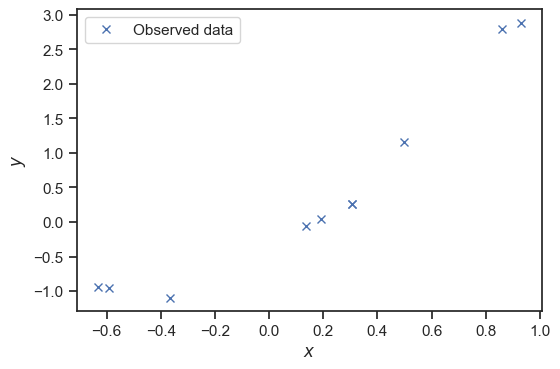

In [2]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code from previous hands-on activities for generating the design matrix and fitting the models.

In [3]:
import scipy

def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

def find_m_and_S(Phi, y, sigma2, alpha):
    """Return the posterior mean and covariance of the weights
    of a Bayesian linear regression problem.
    
    Arguments:
    Phi    -- The design matrix.
    y      -- The observed targets.
    sigma2 -- The noise variance.
    alpha  -- The prior weight precision.
    """
    A = (
        Phi.T @ Phi / sigma2
        + alpha * np.eye(Phi.shape[1])
    )
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(
        L,
        Phi.T @ y / sigma2
    )
    S = scipy.linalg.cho_solve(
        L,
        np.eye(Phi.shape[1])
    )
    return m, S

Fit a $7$ degree polynomial:

In [4]:
import scipy.stats as st

# Parameters
degree = 7
sigma2 = 0.1 ** 2
alpha = 5.0

# Weight prior
w_prior = st.multivariate_normal(
    mean=np.zeros(degree+1),
    cov=np.eye(degree+1) / alpha
)

# Design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

# Fit
m, S = find_m_and_S(Phi, y, sigma2, alpha)

# Weight posterior
w_post = st.multivariate_normal(mean=m, cov=S)

As we discussed in the video, it is possible to get the posterior point predictive distribution for $y$ conditioned on $\mathbf{x}$ and to separate aleatory from epistemic uncertainty.
The posterior point predictive is:

$$
s^2(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$

+ $\sigma^2$ corresponds to the measurement noise.
+ $\boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x})$ is the epistemic uncertainty induced by limited data.

Here is how to visualize both of these:

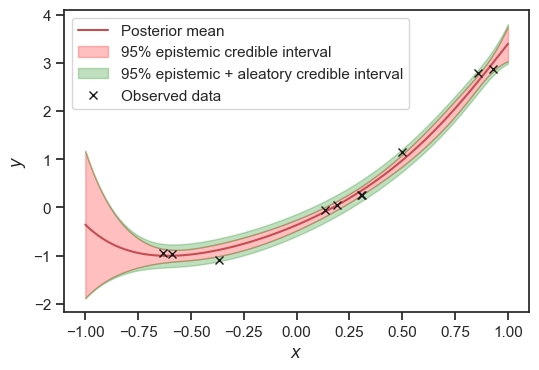

In [5]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

# Posterior predictive mean
yy_mean = Phi_xx @ m
# Posterior predictive epistemic variance
yy_var = np.einsum(
    'ij,jk,ik->i',
    Phi_xx,
    S,
    Phi_xx
)
# Posterior predictive epistemic + aleatory variance
yy_measured_var = yy_var + sigma2
# 95% posterior predictive credible interval
yy_std = np.sqrt(yy_var)
yy_measured_std = np.sqrt(yy_measured_var)
# Epistemic only
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response for plotting
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x, y, 'kx', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case